## Import necessary libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Dense, Flatten, Conv1D, LeakyReLU
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from pickle import load, dump
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings("ignore")

## Load and preprocess data

In [37]:
# Load and preprocess data
company_ticker = 'AMZN'
stock_data = pd.read_csv('processed_amzn_data.csv')
stock_data = stock_data.drop(columns=['target'])

# Handle missing values and set datetime index
stock_dataset = stock_data.reset_index(drop=True)
stock_dataset.iloc[:, 1:] = stock_dataset.iloc[:, 1:].ffill()
date_index = pd.DatetimeIndex(pd.to_datetime(stock_dataset['Date']).values)
stock_dataset = stock_dataset.set_index(date_index).sort_values(by='Date').drop(columns='Date')

# Normalize data
target_column = 'Close'
target_series = pd.DataFrame(stock_dataset[target_column])
feature_data = pd.DataFrame(stock_dataset)

feature_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_features = feature_scaler.fit_transform(feature_data)
normalized_target = target_scaler.fit_transform(target_series)

# Save scalers for later use
dump(feature_scaler, open('feature_scaler.pkl', 'wb'))
dump(target_scaler, open('target_scaler.pkl', 'wb'))

# Prepare batched data
batch_size = 5
prediction_horizon = 1
X_batched, y_batched, y_context = [], [], []

for i in range(0, len(normalized_features) - batch_size - prediction_horizon + 1):
    x_batch = normalized_features[i:i + batch_size]
    y_batch = normalized_target[i + batch_size:i + batch_size + prediction_horizon, 0]
    y_context_batch = normalized_target[i:i + batch_size]
    X_batched.append(x_batch)
    y_batched.append(y_batch)
    y_context.append(y_context_batch)

X_batched = np.array(X_batched)
y_batched = np.array(y_batched)
y_context = np.array(y_context)

# Split data into train and test sets
train_size = int(len(X_batched) * 0.8)
X_train, X_test = X_batched[:train_size], X_batched[train_size:]
y_train, y_test = y_batched[:train_size], y_batched[train_size:]
y_context_train, y_context_test = y_context[:train_size], y_context[train_size:]

## Define the VAE model

In [38]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super().__init__()

        # Encoder
        encoder_layers = []
        for i in range(len(hidden_dims)):
            if i == 0:
                encoder_layers.append(nn.Linear(input_dim, hidden_dims[i]))
            else:
                encoder_layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)

        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder
        decoder_layers = []
        reversed_hidden_dims = hidden_dims[::-1]
        for i in range(len(reversed_hidden_dims)):
            if i == 0:
                decoder_layers.append(nn.Linear(latent_dim, reversed_hidden_dims[i]))
            else:
                decoder_layers.append(nn.Linear(reversed_hidden_dims[i-1], reversed_hidden_dims[i]))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(reversed_hidden_dims[-1], input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Train the VAE
def train_vae(model, data, batch_size, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    data_loader = DataLoader(TensorDataset(torch.from_numpy(data).float()), batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data,) in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(data)
            loss = criterion(recon_batch, data) + 0.5 * torch.sum(torch.exp(log_var) + mu**2 - 1. - log_var)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {train_loss / len(data_loader.dataset):.8f}')

    return model

## Train the VAE

In [27]:
# Set up VAE parameters
input_dim = X_batched.shape[2]
hidden_dims = [64, 32, 16]
latent_dim = 8
vae_batch_size = 64
vae_num_epochs = 1000
vae_learning_rate = 0.00003

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize and train VAE
vae = VAE(input_dim, hidden_dims, latent_dim).to(device)
vae = train_vae(vae, X_batched.reshape(-1, input_dim), vae_batch_size, vae_num_epochs, vae_learning_rate)

Epoch 1, Loss: 0.18520175
Epoch 2, Loss: 0.18039848
Epoch 3, Loss: 0.17570002
Epoch 4, Loss: 0.17125187
Epoch 5, Loss: 0.16647348
Epoch 6, Loss: 0.16176420
Epoch 7, Loss: 0.15753161
Epoch 8, Loss: 0.15306555
Epoch 9, Loss: 0.14877679
Epoch 10, Loss: 0.14431789
Epoch 11, Loss: 0.14005084
Epoch 12, Loss: 0.13572538
Epoch 13, Loss: 0.13162504
Epoch 14, Loss: 0.12770430
Epoch 15, Loss: 0.12386850
Epoch 16, Loss: 0.12000642
Epoch 17, Loss: 0.11643457
Epoch 18, Loss: 0.11327302
Epoch 19, Loss: 0.10972054
Epoch 20, Loss: 0.10661528
Epoch 21, Loss: 0.10365408
Epoch 22, Loss: 0.10088462
Epoch 23, Loss: 0.09830854
Epoch 24, Loss: 0.09561153
Epoch 25, Loss: 0.09348574
Epoch 26, Loss: 0.09105411
Epoch 27, Loss: 0.08877831
Epoch 28, Loss: 0.08681434
Epoch 29, Loss: 0.08470886
Epoch 30, Loss: 0.08267802
Epoch 31, Loss: 0.08078874
Epoch 32, Loss: 0.07874679
Epoch 33, Loss: 0.07693289
Epoch 34, Loss: 0.07533640
Epoch 35, Loss: 0.07341872
Epoch 36, Loss: 0.07174725
Epoch 37, Loss: 0.07009078
Epoch 38, 

## Generate latent representations

In [40]:
# Generate latent representations
vae.eval()
with torch.no_grad():
    _, train_latent, _ = vae(torch.from_numpy(X_train.reshape(-1, input_dim)).float().to(device))
    _, test_latent, _ = vae(torch.from_numpy(X_test.reshape(-1, input_dim)).float().to(device))

# Reshape latent representations
train_latent = train_latent.cpu().numpy().reshape(X_train.shape[0], X_train.shape[1], -1)
test_latent = test_latent.cpu().numpy().reshape(X_test.shape[0], X_test.shape[1], -1)

# Augment original features with latent representations
X_train_augmented = np.concatenate((X_train, train_latent), axis=2)
X_test_augmented = np.concatenate((X_test, test_latent), axis=2)

# Update input dimensions for the GAN model
input_dim = X_train_augmented.shape[1]
feature_size = X_train_augmented.shape[2]
output_dim = y_train.shape[1]


## Define GAN models

In [41]:
# Generator model
generator = tf.keras.Sequential([
    LSTM(1024, return_sequences=True, input_shape=(input_dim, feature_size), recurrent_dropout=0.3),
    LSTM(512, return_sequences=True, recurrent_dropout=0.3),
    LSTM(256, return_sequences=True, recurrent_dropout=0.3),
    LSTM(128, return_sequences=True, recurrent_dropout=0.3),
    LSTM(64, recurrent_dropout=0.3),
    Dense(32),
    Dense(16),
    Dense(8),
    Dense(output_dim)
])

# Discriminator model
discriminator = tf.keras.Sequential([
    Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
    Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
    Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
    Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
    Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
    Flatten(),
    Dense(220, use_bias=False),
    LeakyReLU(),
    Dense(220, use_bias=False, activation='relu'),
    Dense(1, activation='sigmoid')
])

## Define loss functions and training step

In [42]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Update the train_step function to handle the shape mismatch
@tf.function
def train_step(real_x, real_y, y_context):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        # Reshape generated_data to match y_context shape
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        # Ensure y_context has the correct shape
        y_context_reshaped = tf.reshape(y_context, [y_context.shape[0], y_context.shape[1], 1])

        # Concatenate along the correct axis (now axis=1)
        fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), y_context_reshaped], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        real_input = tf.concat([real_y_reshape, y_context_reshaped], axis=1)

        real_output = discriminator(real_input, training=True)
        fake_output = discriminator(fake_input, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return real_y, generated_data, {'disc_loss': disc_loss, 'gen_loss': gen_loss}


## Train the GAN

  5%|▌         | 102/2000 [01:06<01:58, 16.03it/s]

Epoch 100, Discriminator Loss: 1.386674165725708, Generator Loss: 0.6930608749389648


 10%|█         | 203/2000 [01:11<01:47, 16.68it/s]

Epoch 200, Discriminator Loss: 1.385242223739624, Generator Loss: 0.6895478963851929


 15%|█▌        | 302/2000 [01:16<01:55, 14.71it/s]

Epoch 300, Discriminator Loss: 1.38620126247406, Generator Loss: 0.7133181691169739


 20%|██        | 404/2000 [01:21<01:27, 18.31it/s]

Epoch 400, Discriminator Loss: 1.3865530490875244, Generator Loss: 0.6927458643913269


 25%|██▌       | 502/2000 [01:26<01:35, 15.62it/s]

Epoch 500, Discriminator Loss: 1.3863554000854492, Generator Loss: 0.6930895447731018


 30%|███       | 604/2000 [01:33<02:12, 10.55it/s]

Epoch 600, Discriminator Loss: 1.3862073421478271, Generator Loss: 0.6920993328094482


 35%|███▌      | 703/2000 [01:38<01:14, 17.39it/s]

Epoch 700, Discriminator Loss: 1.3867417573928833, Generator Loss: 0.6926178932189941


 40%|████      | 802/2000 [01:44<01:08, 17.42it/s]

Epoch 800, Discriminator Loss: 1.3863544464111328, Generator Loss: 0.6928955912590027


 45%|████▌     | 903/2000 [01:49<01:00, 18.26it/s]

Epoch 900, Discriminator Loss: 1.386237621307373, Generator Loss: 0.6913227438926697


 50%|█████     | 1004/2000 [01:55<01:04, 15.45it/s]

Epoch 1000, Discriminator Loss: 1.3866455554962158, Generator Loss: 0.6898598670959473


 55%|█████▌    | 1102/2000 [02:00<00:53, 16.70it/s]

Epoch 1100, Discriminator Loss: 1.3859919309616089, Generator Loss: 0.6970058679580688


 60%|██████    | 1201/2000 [02:04<00:49, 16.02it/s]

Epoch 1200, Discriminator Loss: 1.385717511177063, Generator Loss: 0.6971398591995239


 65%|██████▌   | 1303/2000 [02:10<00:40, 17.38it/s]

Epoch 1300, Discriminator Loss: 1.3864789009094238, Generator Loss: 0.6919991970062256


 70%|███████   | 1402/2000 [02:15<00:35, 16.65it/s]

Epoch 1400, Discriminator Loss: 1.3859972953796387, Generator Loss: 0.6944711804389954


 75%|███████▌  | 1503/2000 [02:21<00:29, 16.80it/s]

Epoch 1500, Discriminator Loss: 1.3865761756896973, Generator Loss: 0.700921893119812


 80%|████████  | 1602/2000 [02:26<00:23, 17.19it/s]

Epoch 1600, Discriminator Loss: 1.385823130607605, Generator Loss: 0.6934936046600342


 85%|████████▌ | 1703/2000 [02:31<00:22, 12.93it/s]

Epoch 1700, Discriminator Loss: 1.3861079216003418, Generator Loss: 0.6919839382171631


 90%|█████████ | 1800/2000 [02:37<00:17, 11.30it/s]

Epoch 1800, Discriminator Loss: 1.3831310272216797, Generator Loss: 0.6882167458534241


 95%|█████████▌| 1902/2000 [02:49<00:09,  9.99it/s]

Epoch 1900, Discriminator Loss: 1.3855388164520264, Generator Loss: 0.6924264430999756


100%|██████████| 2000/2000 [02:54<00:00, 11.46it/s]


Epoch 2000, Discriminator Loss: 1.386763334274292, Generator Loss: 0.6933766007423401


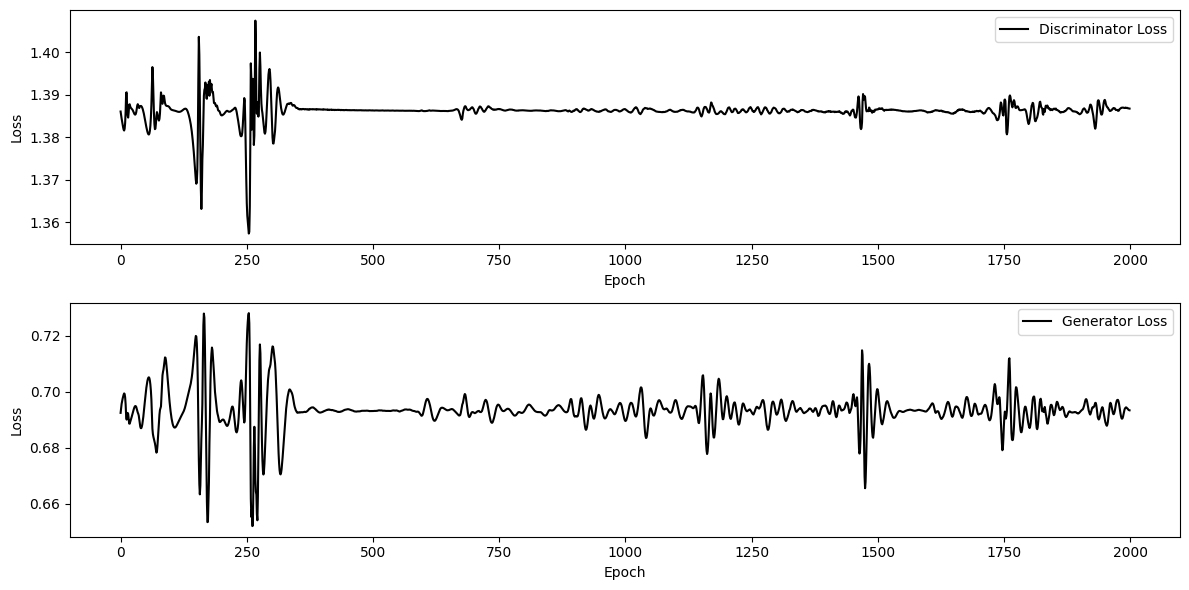

In [29]:
# Train the GAN
learning_rate = 3e-4
epochs = 2000
checkpoint_interval = 100

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

training_history = {
    "discriminator_loss": [],
    "generator_loss": []
}

# Before training, ensure that y_context_train has the correct shape
y_context_train = y_context_train.reshape(y_context_train.shape[0], y_context_train.shape[1], 1)

for epoch in tqdm(range(epochs)):
    real_price, fake_price, losses = train_step(X_train_augmented, y_train, y_context_train)

    training_history["discriminator_loss"].append(losses['disc_loss'].numpy())
    training_history["generator_loss"].append(losses['gen_loss'].numpy())

    if (epoch + 1) % checkpoint_interval == 0:
        tf.keras.models.save_model(generator, f'./models_gan/{company_ticker}/generator_epoch_{epoch}.h5')
        tf.keras.models.save_model(discriminator, f'./models_gan/{company_ticker}/discriminator_epoch_{epoch}.h5')
        print(f'Epoch {epoch + 1}, Discriminator Loss: {losses["disc_loss"].numpy()}, Generator Loss: {losses["gen_loss"].numpy()}')

# Plot training losses
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(training_history["discriminator_loss"], label='Discriminator Loss', color='#000000')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(training_history["generator_loss"], label='Generator Loss', color='#000000')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate the model

Using device: cuda:0


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Train Set Evaluation:
Mean Squared Error: 30.0116
Root Mean Squared Error: 5.4783
Mean Absolute Error: 4.2017
Mean Absolute Percentage Error: 3.0975%
R-squared Score: 0.9444

Test Set Evaluation:
Mean Squared Error: 20.4760
Root Mean Squared Error: 4.5250
Mean Absolute Error: 3.2585
Mean Absolute Percentage Error: 2.6134%
R-squared Score: 0.5138


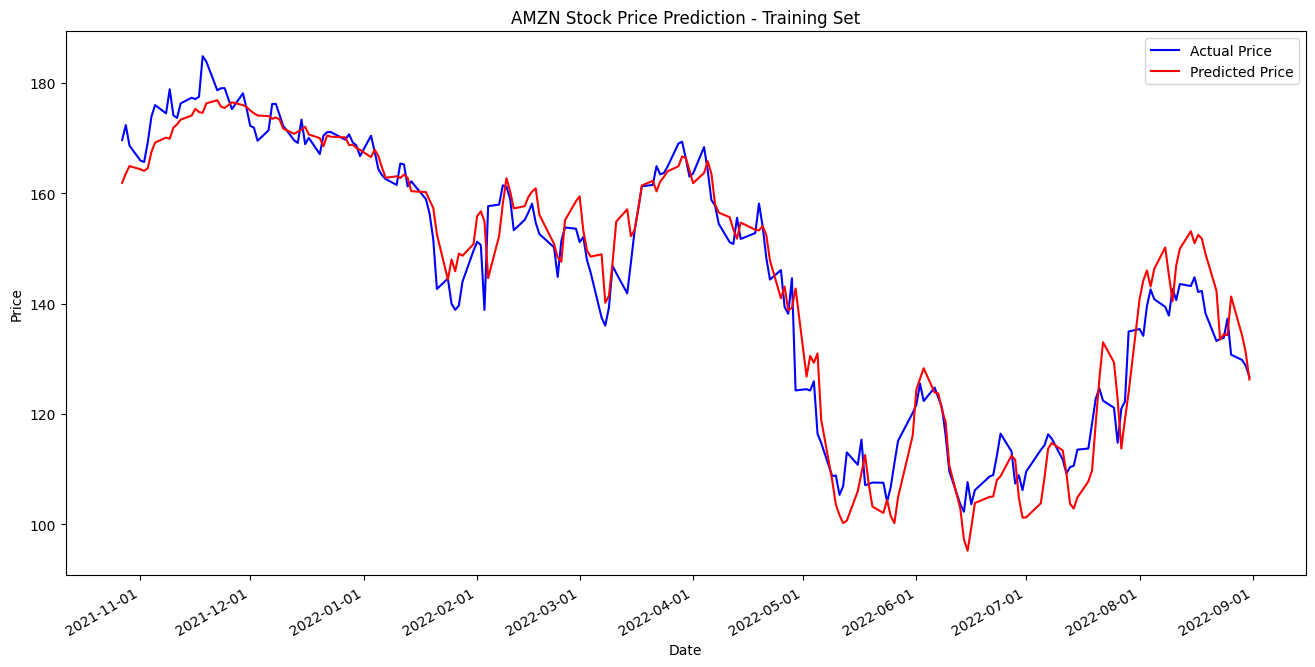

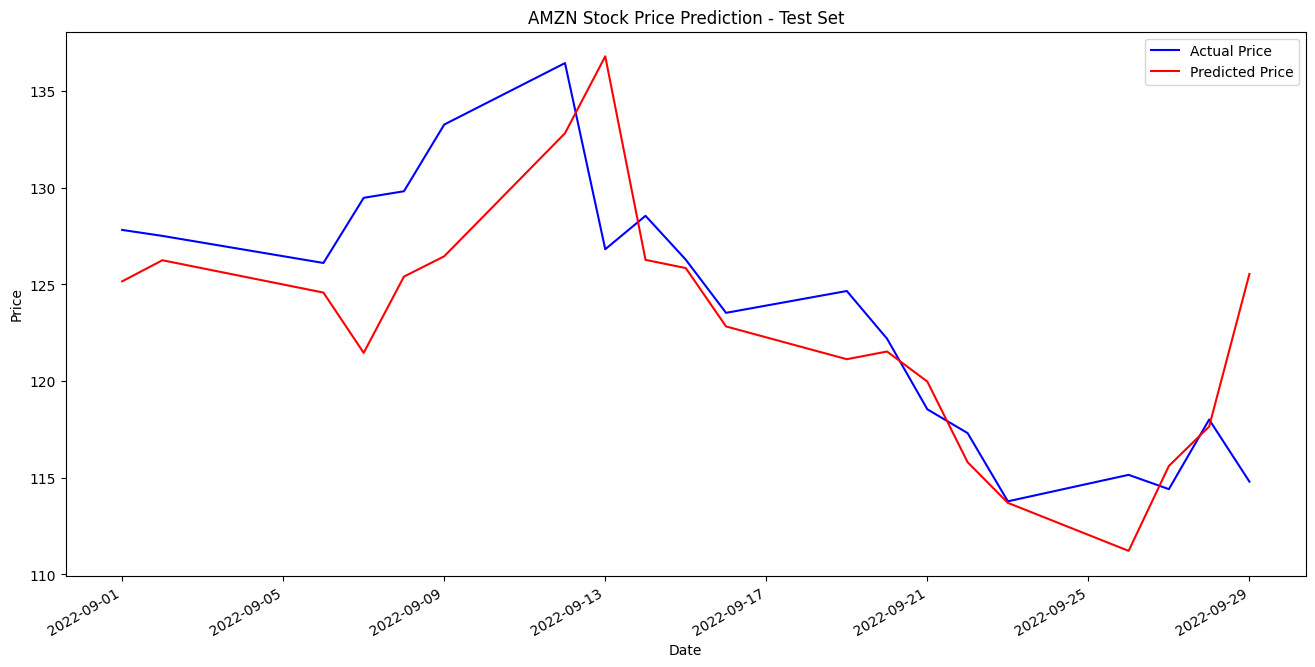

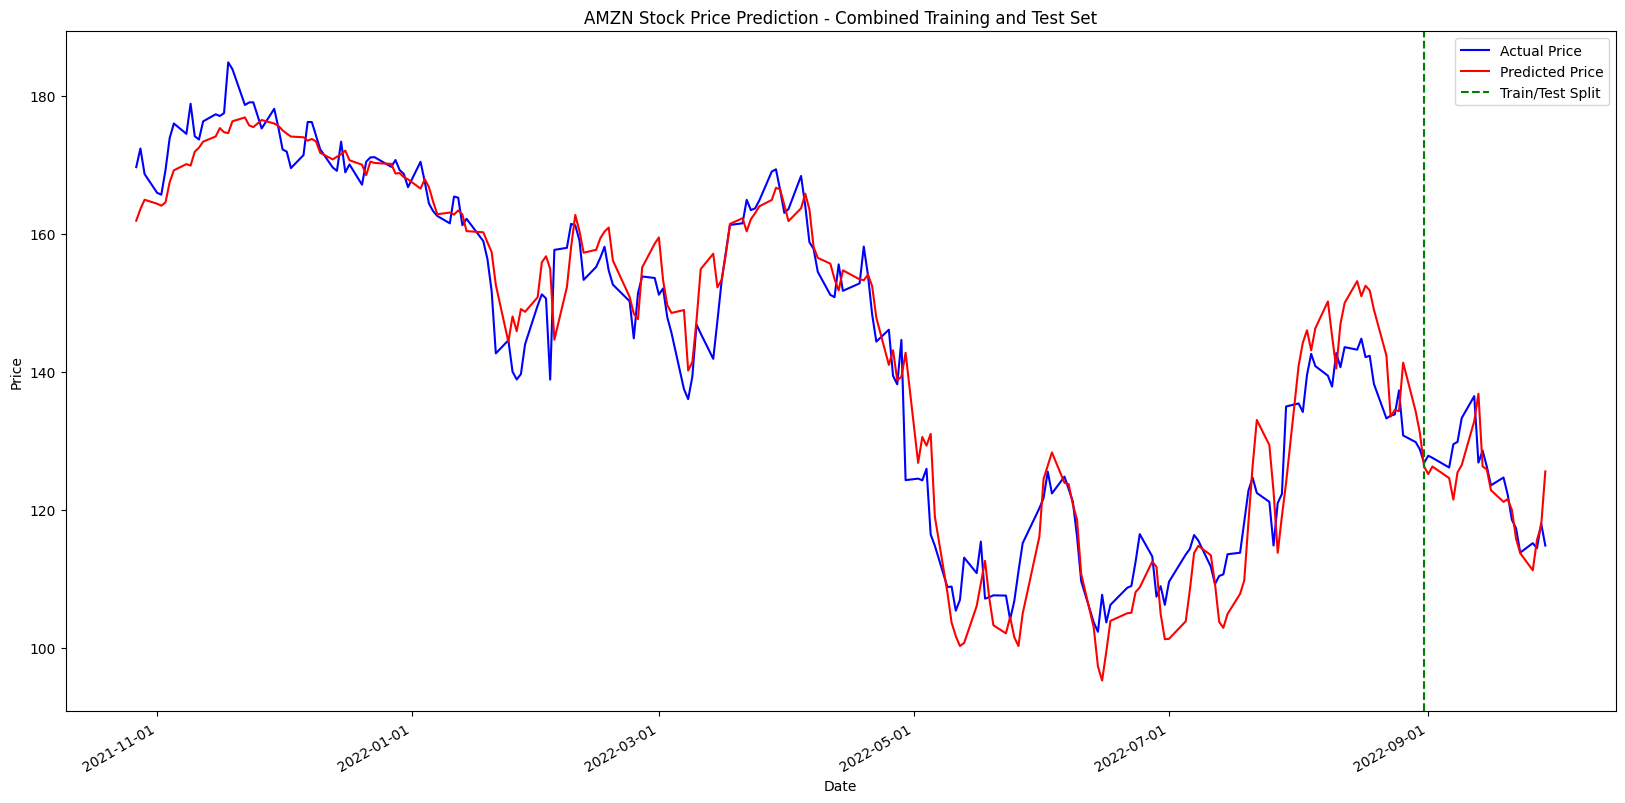

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.dates as mdates

# Check for CUDA availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def evaluate_predictions(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    r2 = r2_score(true_values, predicted_values)

    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Mean Absolute Percentage Error: {mape:.4f}%')
    print(f'R-squared Score: {r2:.4f}')

# Load the best generator model
company_ticker = 'AMZN'  # Make sure this matches your actual ticker
epochs = 2000  # Make sure this matches the number of epochs used in training
best_generator = tf.keras.models.load_model(f'./models_gan/{company_ticker}/generator_epoch_{epochs-1}.h5')

# Compile the model to address the warning
best_generator.compile(optimizer='adam', loss='mse')

# Load the VAE model
vae.eval()

# Move VAE to the correct device
vae = vae.to(device)

# Generate latent representations for train and test data
with torch.no_grad():
    _, train_latent, _ = vae(torch.from_numpy(X_train.reshape(-1, X_train.shape[2])).float().to(device))
    _, test_latent, _ = vae(torch.from_numpy(X_test.reshape(-1, X_test.shape[2])).float().to(device))

# Move latent representations back to CPU for numpy operations
train_latent = train_latent.cpu().numpy().reshape(X_train.shape[0], X_train.shape[1], -1)
test_latent = test_latent.cpu().numpy().reshape(X_test.shape[0], X_test.shape[1], -1)

# Augment original features with latent representations
X_train_augmented = np.concatenate((X_train, train_latent), axis=2)
X_test_augmented = np.concatenate((X_test, test_latent), axis=2)

# Generate predictions on train and test data
train_predictions = best_generator.predict(X_train_augmented)
test_predictions = best_generator.predict(X_test_augmented)

# Inverse transform the predictions and actual values
y_scaler = load(open('target_scaler.pkl', 'rb'))
actual_train_prices = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
predicted_train_prices = y_scaler.inverse_transform(train_predictions).flatten()
actual_test_prices = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_test_prices = y_scaler.inverse_transform(test_predictions).flatten()

# Evaluate train set predictions
print("Train Set Evaluation:")
evaluate_predictions(actual_train_prices, predicted_train_prices)

# Evaluate test set predictions
print("\nTest Set Evaluation:")
evaluate_predictions(actual_test_prices, predicted_test_prices)

# Get the dates for plotting
all_dates = pd.to_datetime(stock_dataset.index)
train_dates = all_dates[batch_size:len(actual_train_prices)+batch_size]
test_dates = all_dates[len(actual_train_prices)+batch_size:]

# Ensure all arrays have the same length
min_train_length = min(len(train_dates), len(actual_train_prices), len(predicted_train_prices))
min_test_length = min(len(test_dates), len(actual_test_prices), len(predicted_test_prices))

train_dates = train_dates[:min_train_length]
actual_train_prices = actual_train_prices[:min_train_length]
predicted_train_prices = predicted_train_prices[:min_train_length]

test_dates = test_dates[:min_test_length]
actual_test_prices = actual_test_prices[:min_test_length]
predicted_test_prices = predicted_test_prices[:min_test_length]

# Plot training set predictions
plt.figure(figsize=(16, 8))
plt.plot(train_dates, actual_train_prices, label='Actual Price', color='blue')
plt.plot(train_dates, predicted_train_prices, label='Predicted Price', color='red')
plt.title(f'{company_ticker} Stock Price Prediction - Training Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
plt.show()

# Plot test set predictions
plt.figure(figsize=(16, 8))
plt.plot(test_dates, actual_test_prices, label='Actual Price', color='blue')
plt.plot(test_dates, predicted_test_prices, label='Predicted Price', color='red')
plt.title(f'{company_ticker} Stock Price Prediction - Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
plt.show()

# Combine train and test predictions
all_dates = np.concatenate([train_dates, test_dates])
all_actual = np.concatenate([actual_train_prices, actual_test_prices])
all_pred = np.concatenate([predicted_train_prices, predicted_test_prices])

# Plot combined training and test set predictions
plt.figure(figsize=(20, 10))
plt.plot(all_dates, all_actual, label='Actual Price', color='blue')
plt.plot(all_dates, all_pred, label='Predicted Price', color='red')
plt.title(f'{company_ticker} Stock Price Prediction - Combined Training and Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
# Add a vertical line to separate training and test sets
plt.axvline(x=train_dates[-1], color='green', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()

## Visualize the model architecture

Generator Architecture:


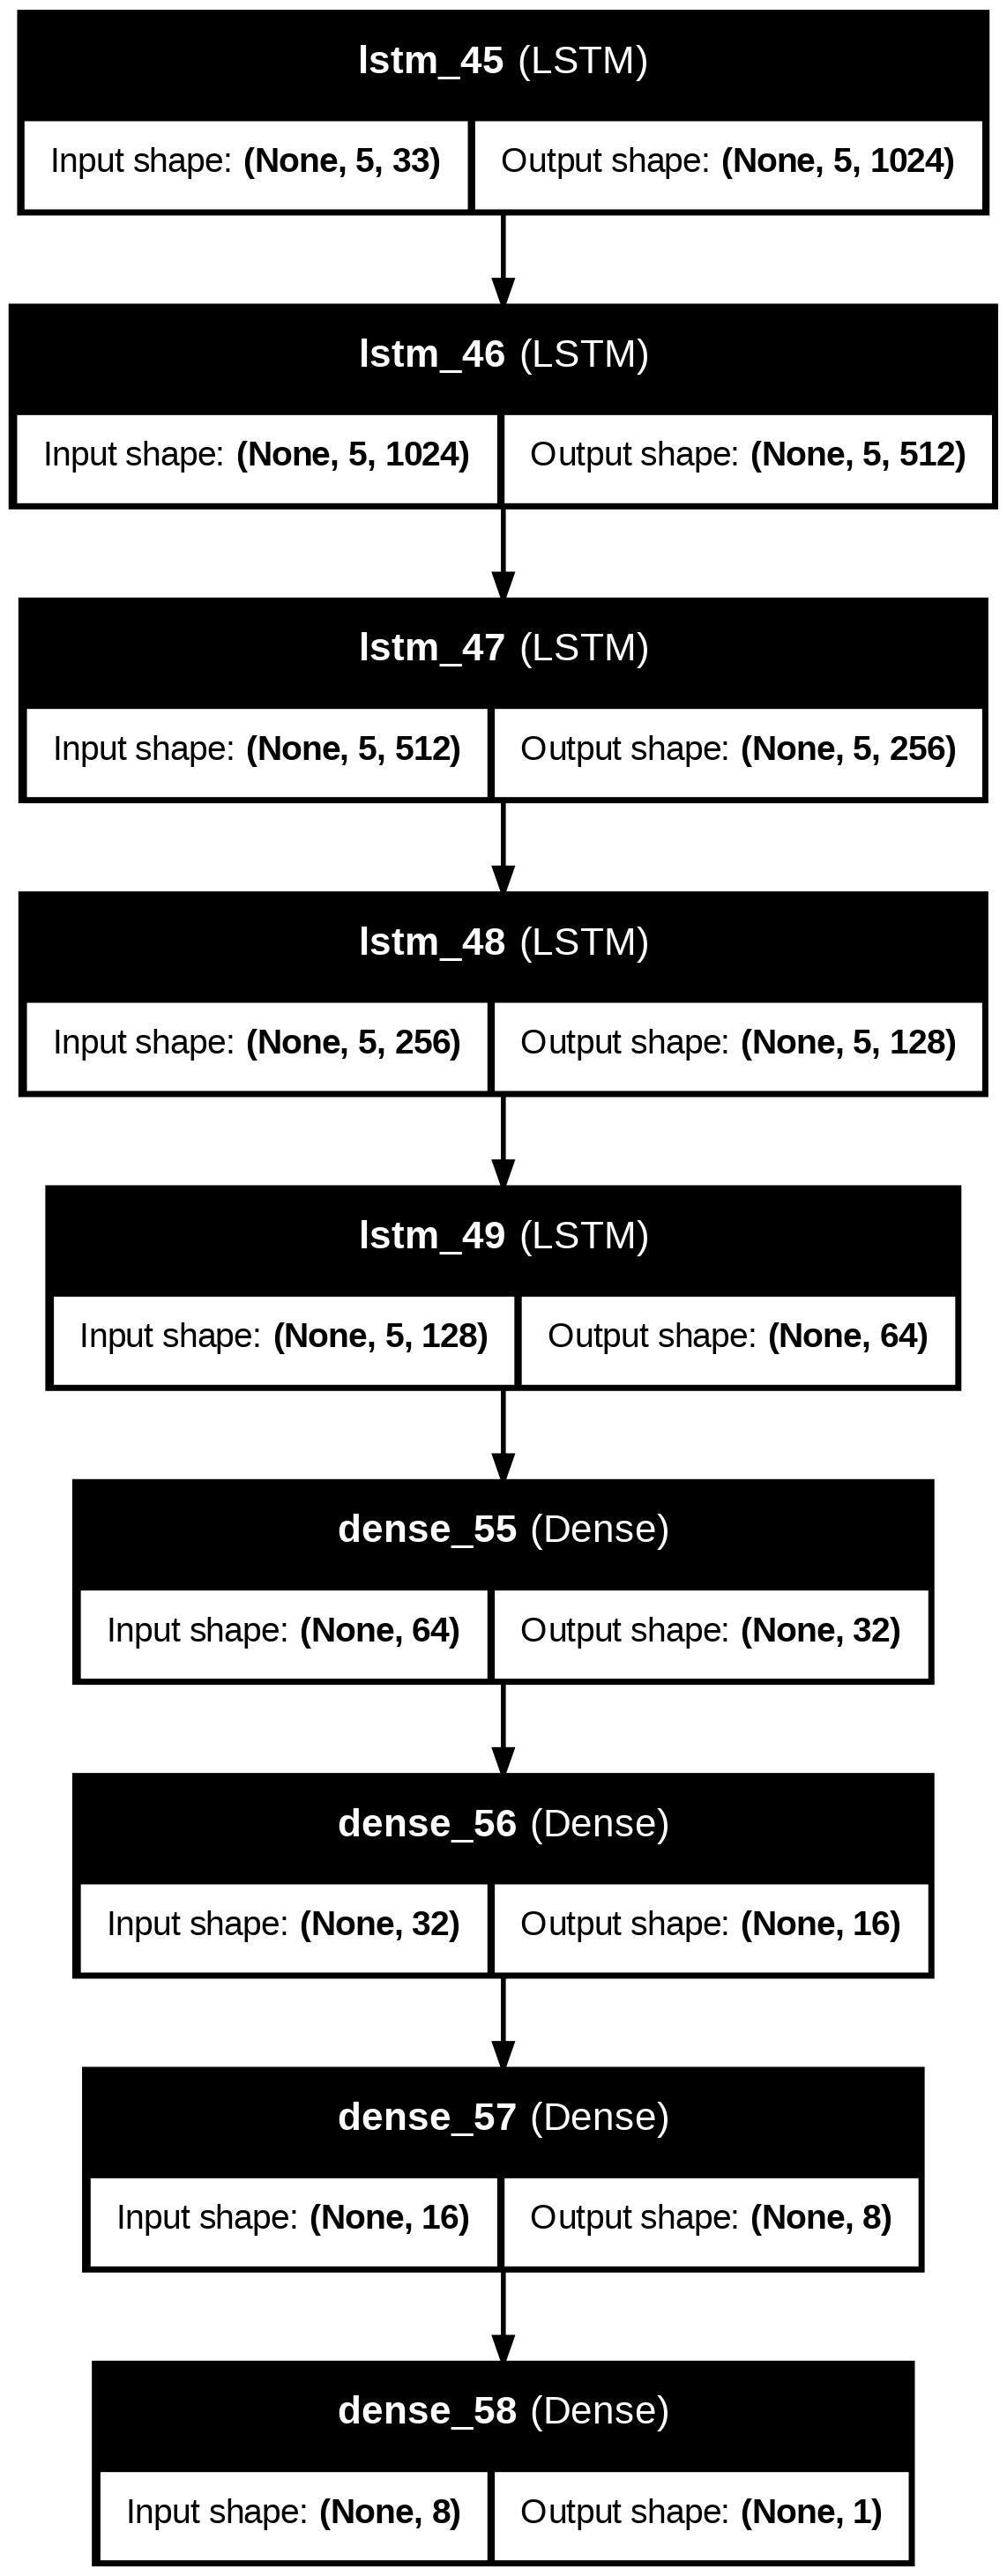


Discriminator Architecture:


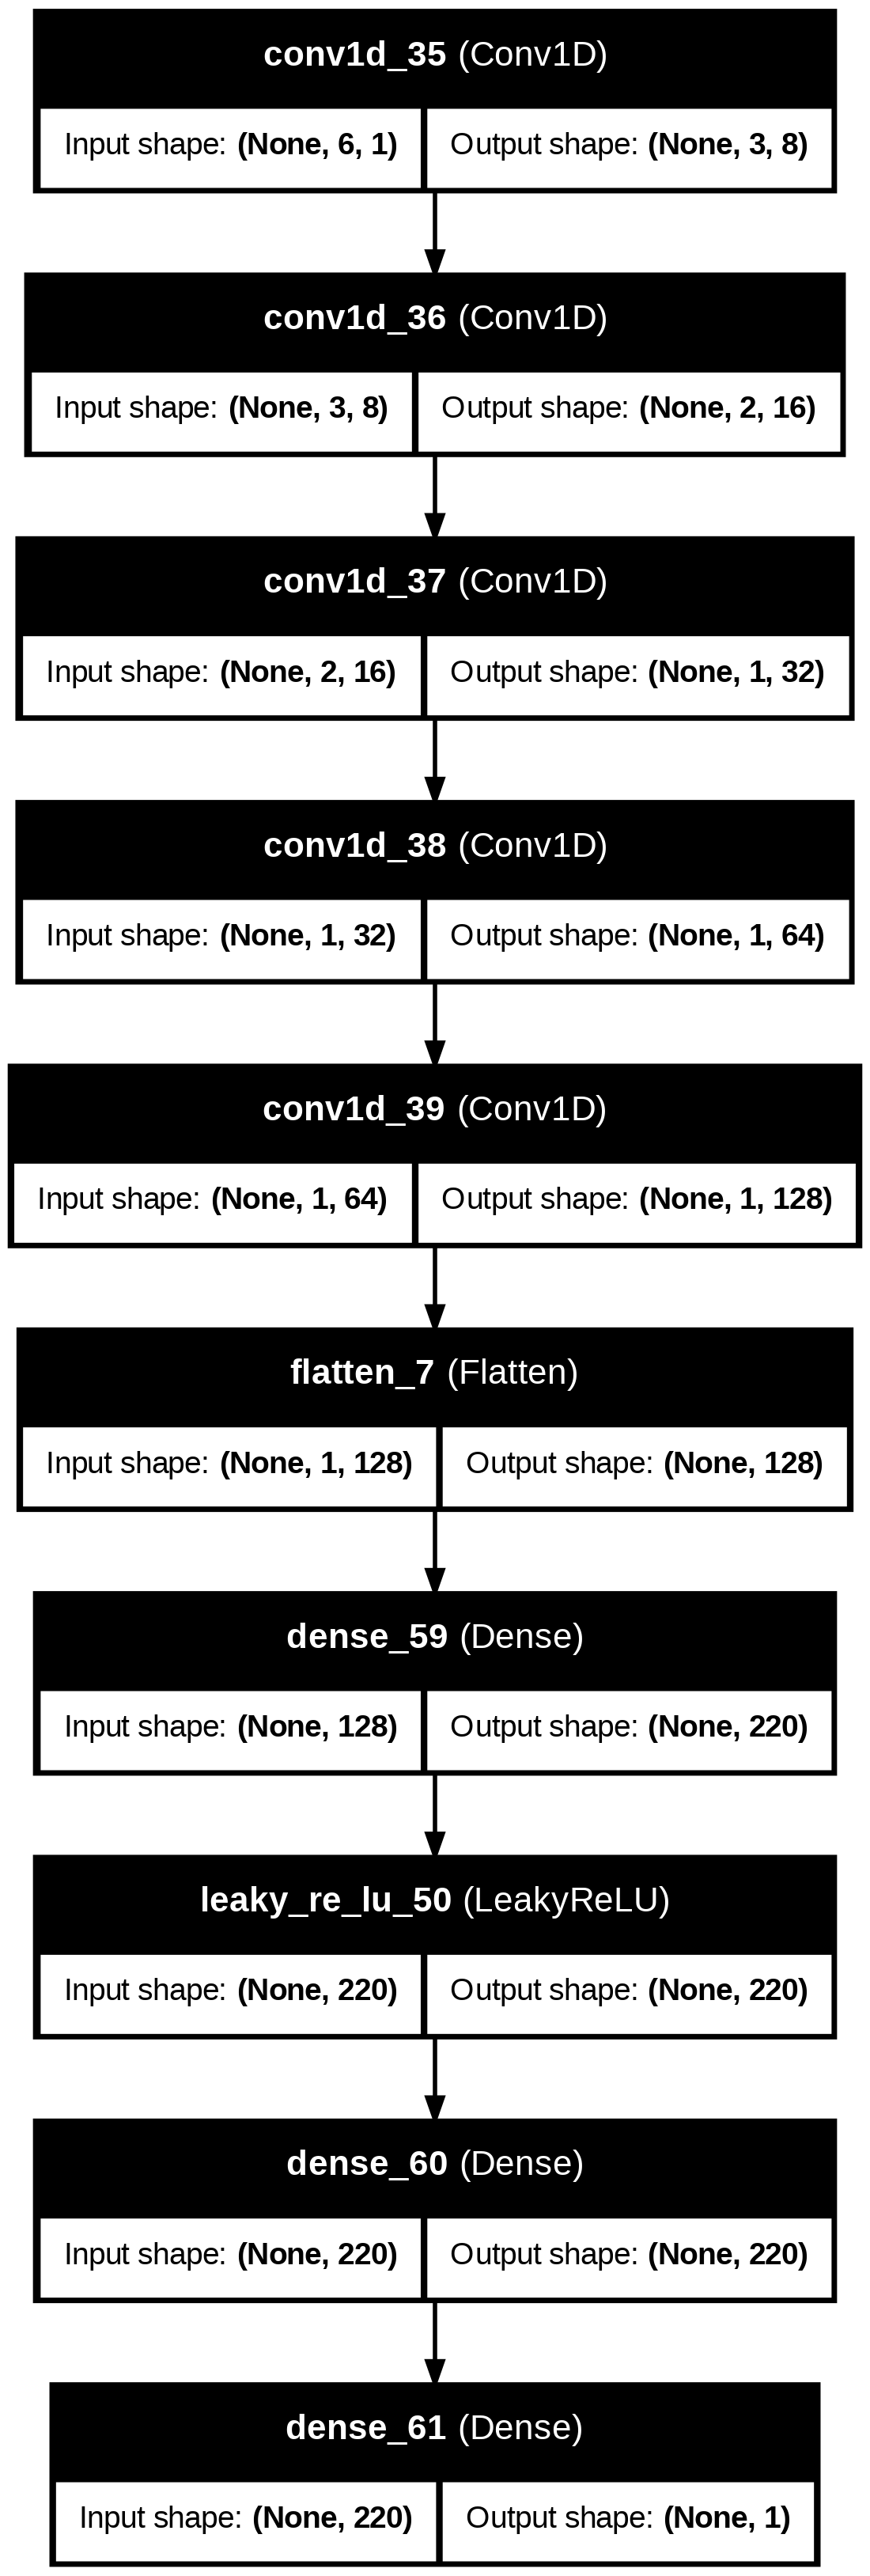

In [45]:
# Visualize the generator model
tf.keras.utils.plot_model(generator, to_file='generator_architecture.png', show_shapes=True, show_layer_names=True)

# Visualize the discriminator model
tf.keras.utils.plot_model(discriminator, to_file='discriminator_architecture.png', show_shapes=True, show_layer_names=True)

# Display the model architectures
from IPython.display import Image, display

print("Generator Architecture:")
display(Image('generator_architecture.png'))

print("\nDiscriminator Architecture:")
display(Image('discriminator_architecture.png'))